In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os

scvi.settings.seed = 1

## Using scVI for dimenstionality reduction

In [3]:
counts = pd.read_csv('data/star_counts.tab.gz', index_col=0)

accession_map = pd.read_csv('data/GSE109774_list_of_SRR_accessions_and_raw_filenames.txt.gz', 
                            sep='\t', index_col=1,
                           names=['GSM', 'fq1', 'fq2'])
annotations = pd.read_csv('data/annotations_facs.csv.gz', index_col=2)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
accession_map = accession_map.loc[counts.columns]
annotations_id = ['.'.join(accession_map.loc[cell].fq1[:-15].split('-')) for cell in counts.columns]
accession_map['annotations_id'] = annotations_id
annotations_cells = annotations.index & pd.Index(annotations_id)

cell_type = []
subtissue = []
sex = []
selected_cells = []
for idx, row in accession_map.iterrows():
    try:
        cell_type.append(annotations.loc[row.annotations_id, 'cell_ontology_class'])
        subtissue.append(annotations.loc[row.annotations_id, 'subtissue'])
        sex.append(annotations.loc[row.annotations_id, 'mouse.sex'])
        selected_cells.append(idx)
    except:
        continue
#         cell_type.append('unknown')
#         subtissue.append('unknown')
#         sex.append('unknown')
        


In [4]:
counts = counts.T

counts = counts.loc[selected_cells]

adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


scvi.data.setup_anndata(adata, layer="counts")

sc.set_figure_params(figsize=(4, 4))


sc.pp.highly_variable_genes(
    adata,
    n_top_genes=10000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# scvi.data.setup_anndata(adata, layer="counts") # this might be needed
# model = scvi.model.SCVI(adata)
# model.train()
# model.save("data/tabula_muris_scvi/")
# adata.write_csvs('data/tabula_muris_anndata')

model = scvi.model.SCVI.load("data/tabula_muris_scvi/", adata)



latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

sc.tl.pca(adata)


adata.obs['cell_type'] = cell_type
adata.obs['subtissue'] = subtissue
adata.obs['sex'] = sex

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6169 cells, 32045 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

In [5]:
# scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
# scvi_rd.index = adata.obs.index
# scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 11)]

# scvi_rd.to_csv('data/tabula_muris_scvi_rd.tab.gz', sep='\t', index=True, header=True)

... storing 'cell_type' as categorical
... storing 'subtissue' as categorical
... storing 'sex' as categorical


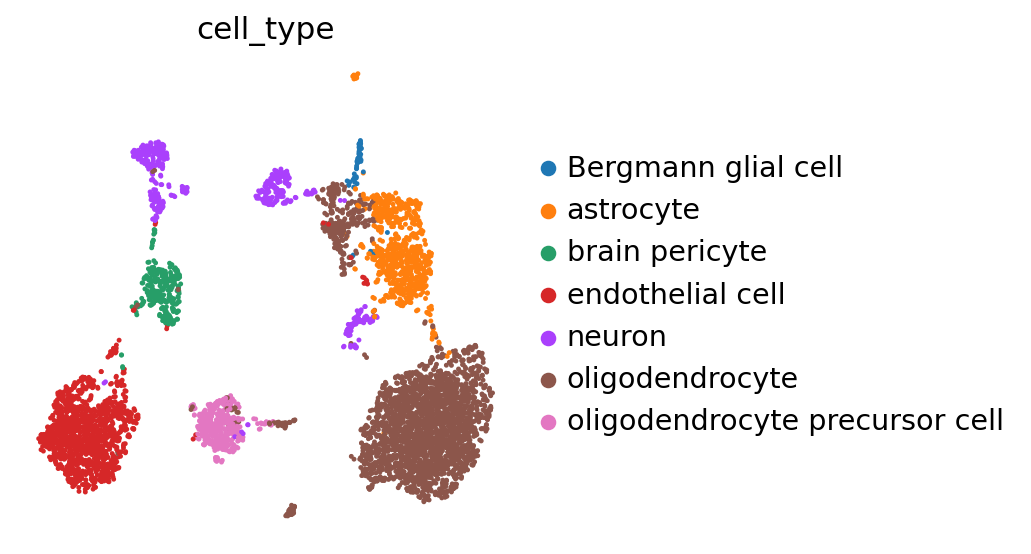

In [6]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

sc.tl.pca(adata)


sc.pl.umap(
    adata,
    color="cell_type",
    frameon=False,
)

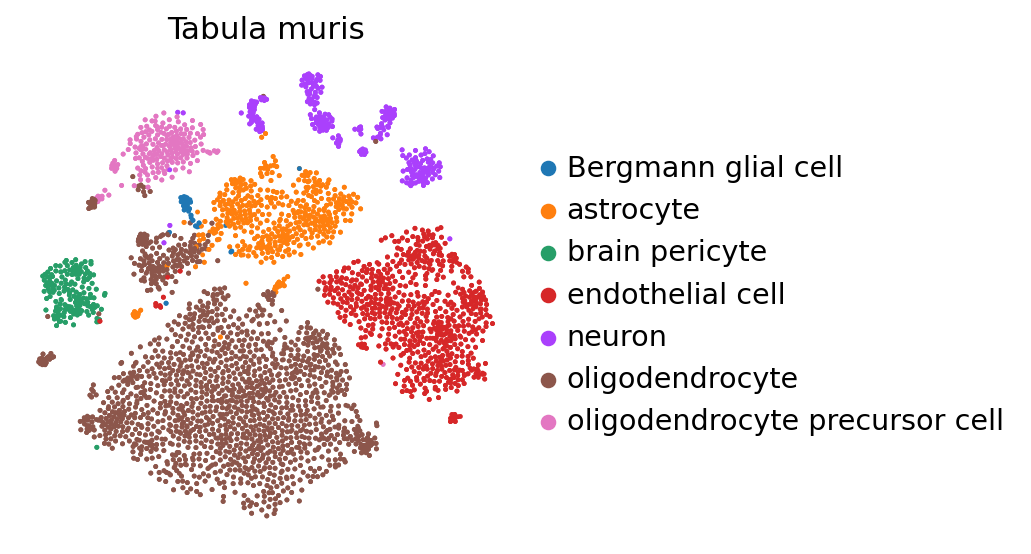

In [7]:
sc.tl.tsne(adata)
sc.pl.tsne(
    adata,
    color="cell_type",
    title='Tabula muris',
    frameon=False,
)

In [13]:
umap_rd = pd.DataFrame(adata.obsm['X_umap'])
umap_rd.index = adata.obs.index
umap_rd.columns = ['umap_' + str(x) for x in range(1, 3)]

umap_rd.to_csv('data/tabula_muris_umap_rd.tab.gz', sep='\t', index=True, header=True)

tsne_rd = pd.DataFrame(adata.obsm['X_tsne'])
tsne_rd.index = adata.obs.index
tsne_rd.columns = ['tsne_' + str(x) for x in range(1, 3)]

tsne_rd.to_csv('data/tabula_muris_tsne_rd.tab.gz', sep='\t', index=True, header=True)

## Running Psix

In [2]:
import numpy as np
import pandas as pd
from psix import Psix
import seaborn as sns

Notice that we are using ```dtype=np.float16```. This is because this is a large dataset.

In [2]:
psix_object = Psix()
psix_object.junctions2psi(
        'data/SJ_tables/',
        '../midbrain_development/data/mm10_introns.tab.gz',
        'data/rsem_gene_tpm_filtered.tab.gz',
        save_files_in='psix_object/',
        minJR = 1,
        minCell=1,
        min_observed = 0.1,
    dtype=np.float16
    )

100%|██████████| 6169/6169 [05:37<00:00, 18.26it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 6169/6169 [03:15<00:00, 31.53it/s]


Successfully processed RNA-seq data


In [3]:
psix_object.run_psix(latent='data/tabula_muris_scvi_rd.tab.gz', n_jobs=25)

Computing cell-cell metric...


100%|██████████| 6146/6146 [00:00<00:00, 6570.98it/s]

Successfully computed cell-cell metric
Computing Psix score in 3025 exons



100%|██████████| 3025/3025 [02:24<00:00, 20.87it/s]  


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [51:58<00:00, 124.72s/it]   


Successfully estimated p-values


In [5]:
psix_object.psix_results

,psix_score,pvals,qvals
Capzb_3,1.762864,0.000500,0.001495
Gpm6b_1,1.148707,0.000500,0.001495
App_1,1.102443,0.000500,0.001495
Psap_3,1.035717,0.000500,0.001495
Aplp2_2,0.739547,0.000500,0.001495
...,...,...,...
Cd81_1,-0.466526,0.894553,0.954169
Car2_1,-0.516326,0.931034,0.969720
Qdpr_1,-0.545304,0.966017,0.984901
Cd81_2,-0.557107,1.000000,1.000000


## Obtaining modules

Successfully computed neighbors


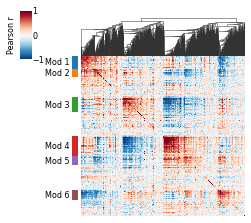

In [8]:
psix_object.compute_modules(plot = True, plot_name = 'exon_modules.png')

In [10]:
psix_object.save_psix_object(psix_dir = '../../tabula_muris_psix_object/')

In [9]:
psix_object = Psix(psix_object = '../../tabula_muris_psix_object/')

### Clusters

In [10]:
psix_object.get_cell_metric(psix_object.latent)

100%|██████████| 6146/6146 [00:00<00:00, 7725.36it/s]

Successfully computed cell-cell metric


In [16]:
SE_phylop = pd.read_csv('../midbrain_development/phylop/SJ_phylop.bed', 
                        names=['chrom', 'bp_start', 'bp_end', 'phylop_id', 'score',
                                                         'chrom_', 'exon_start', 'exon_end', 'exon_name', 'score_',
                                                      'strand'], sep='\t')
exon_phylop = SE_phylop.groupby('exon_name').score.mean()

In [23]:
sig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals < 0.05].index


non_sig_exons = psix_object.psix_results.loc[
    (psix_object.psix_results.qvals >= 0.05)].index

idx = []
for exon in psix_object.psix_results.index:
    idx_5p = SE_phylop.loc[SE_phylop.exon_name == exon + '_5p'].index
    idx_3p = SE_phylop.loc[SE_phylop.exon_name == exon + '_3p'].index
    
    idx.extend(list(idx_5p) + list(idx_3p))
    
SE_phylop_filtered = SE_phylop.loc[idx].shape


mean_phylop_5p = []
mean_phylop_3p = []

counts_sig = 0
for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)[20:40]
            score_3p = list(slice_exon_3p.score)[20:40]
        else:
            score_5p = list(slice_exon_5p.score)[::-1][20:40]
            score_3p = list(slice_exon_3p.score)[::-1][20:40]

        mean_phylop_5p.append(np.mean(score_5p))
        mean_phylop_3p.append(np.mean(score_3p))
        counts_sig += 1
    except:
        continue

counts_non_sig = 0
for exon in tqdm(non_sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)[20:40]
            score_3p = list(slice_exon_3p.score)[20:40]
        else:
            score_5p = list(slice_exon_5p.score)[::-1][20:40]
            score_3p = list(slice_exon_3p.score)[::-1][20:40]

        mean_phylop_5p.append(np.mean(score_5p))
        mean_phylop_3p.append(np.mean(score_3p))
        counts_non_sig += 1
    except:
        continue

scores_df = pd.DataFrame()
scores_df['exon type'] = (['significant']*counts_sig) + (['non significant']*counts_non_sig)
scores_df["score 5'"] = mean_phylop_5p
scores_df["score 3'"] = mean_phylop_3p

NameError: name 'tqdm' is not defined

In [ ]:
sns.boxplot(x='exon type', y="score 5'", data=scores_df)

In [9]:
cell_types = annotations.loc[accession_map.loc[psix_object.latent.index].annotations_id].cell_ontology_class
cell_types = pd.DataFrame(cell_types)
cell_types.index = psix_object.latent.index
cell_types

,cell_ontology_class
SRR6531548,oligodendrocyte precursor cell
SRR6531550,oligodendrocyte
SRR6531555,astrocyte
SRR6531556,astrocyte
SRR6531557,astrocyte
...,...
SRR6542124,oligodendrocyte
SRR6542125,oligodendrocyte
SRR6542126,oligodendrocyte
SRR6542127,oligodendrocyte


In [33]:
neighbors_confusion = pd.DataFrame(np.zeros((7, 7)), 
                                   index = ['oligodendrocyte precursor cell', 'oligodendrocyte', 'astrocyte',
       'neuron', 'endothelial cell', 'brain pericyte',
       'Bergmann glial cell'],
                                  columns = ['oligodendrocyte precursor cell', 'oligodendrocyte', 'astrocyte',
       'neuron', 'endothelial cell', 'brain pericyte',
       'Bergmann glial cell'])

In [34]:
opc = 0
o = 0
a = 0
n = 0
ec = 0
bp = 0
bgc = 0

for i in range(psix_object.metric[0].shape[0]):
    
    cell_i = psix_object.latent.iloc[psix_object.metric[0][i]].index[0]
    cell_i_neighbors = psix_object.latent.iloc[psix_object.metric[0][i]].index[1:]
    
    cell_i_type = cell_types.loc[cell_i].cell_ontology_class
    
    if cell_i_type == 'oligodendrocyte precursor cell':
        opc += np.mean(psix_object.metric[1][i][1:])
    elif cell_i_type == 'oligodendrocyte':
        o += np.mean(psix_object.metric[1][i][1:])
    elif cell_i_type == 'astrocyte':
        a += np.mean(psix_object.metric[1][i][1:])
    elif cell_i_type == 'neuron':
        n += np.mean(psix_object.metric[1][i][1:])
    elif cell_i_type == 'endothelial cell':
        ec += np.mean(psix_object.metric[1][i][1:])
    elif cell_i_type == 'brain pericyte':
        bp += np.mean(psix_object.metric[1][i][1:])
    else:
        bgc += np.mean(psix_object.metric[1][i][1:])
        
    
    neighbors = cell_types.loc[cell_i_neighbors]
    
    neighbors_confusion.loc[cell_i_type, 'oligodendrocyte precursor cell'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'oligodendrocyte precursor cell')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'oligodendrocyte'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'oligodendrocyte')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'astrocyte'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'astrocyte')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'neuron'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'neuron')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'endothelial cell'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'endothelial cell')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'brain pericyte'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'brain pericyte')* psix_object.metric[1][i][1:])
    neighbors_confusion.loc[cell_i_type, 'Bergmann glial cell'] += np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'Bergmann glial cell')* psix_object.metric[1][i][1:])
    


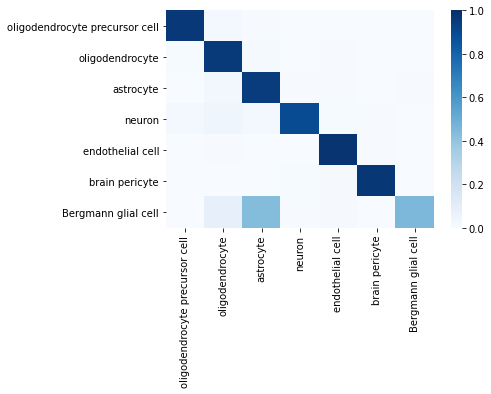

In [37]:
import seaborn as sns
sns.heatmap(
    neighbors_confusion.divide(pd.Series([opc, o, a, n, ec, bp, bgc], index = neighbors_confusion.index), axis=0),
    cmap='Blues', vmin=0, vmax=1
)

In [ ]:
neighbors_confusion.divide(pd.Series([opc, o, a, n, ec, bp, bgc], index = neighbors_confusion.index), axis=1).sum(axis=1)

In [36]:
neighbors_confusion.divide(pd.Series([opc, o, a, n, ec, bp, bgc], index = neighbors_confusion.index), axis=0)

,oligodendrocyte precursor cell,oligodendrocyte,astrocyte,neuron,endothelial cell,brain pericyte,Bergmann glial cell
oligodendrocyte precursor cell,0.968109,0.020410,0.007532,0.002137,0.001792,0.000000,0.000020
oligodendrocyte,0.008097,0.960136,0.018505,0.003495,0.006015,0.002356,0.001395
astrocyte,0.002471,0.030257,0.951650,0.004676,0.005591,0.001174,0.004180
neuron,0.021080,0.044245,0.025646,0.895331,0.007858,0.004706,0.001134
endothelial cell,0.000999,0.004438,0.001782,0.000779,0.984332,0.007506,0.000164
brain pericyte,0.000000,0.003861,0.000476,0.008599,0.015602,0.971462,0.000000
Bergmann glial cell,0.000000,0.085150,0.439320,0.007538,0.011740,0.001135,0.455118


In [14]:
bgc

58

In [17]:
psix_object.latent.iloc[psix_object.metric[0][i]].index[1:]

Index(['SRR6531550', 'SRR6539334', 'SRR6537529', 'SRR6539325', 'SRR6539335',
       'SRR6539326', 'SRR6538515', 'SRR6538516', 'SRR6539294', 'SRR6540441',
       'SRR6539295', 'SRR6537551', 'SRR6531854', 'SRR6534952', 'SRR6540439',
       'SRR6537482', 'SRR6533960', 'SRR6534950', 'SRR6531711', 'SRR6534360',
       'SRR6533959', 'SRR6531710', 'SRR6536684', 'SRR6540279', 'SRR6536795',
       'SRR6534361', 'SRR6540278', 'SRR6531853', 'SRR6539743', 'SRR6534111',
       'SRR6531713', 'SRR6533890', 'SRR6534312', 'SRR6531712', 'SRR6537601',
       'SRR6534313', 'SRR6536222', 'SRR6536223', 'SRR6533512', 'SRR6531825',
       'SRR6534110', 'SRR6533891', 'SRR6534756', 'SRR6537509', 'SRR6541523',
       'SRR6540088', 'SRR6539304', 'SRR6531924', 'SRR6541524', 'SRR6534223',
       'SRR6534299', 'SRR6531822', 'SRR6534300', 'SRR6539680', 'SRR6537559',
       'SRR6540087', 'SRR6537469', 'SRR6537669', 'SRR6531828', 'SRR6539138',
       'SRR6538317', 'SRR6533940', 'SRR6538319', 'SRR6534755', 'SRR6534278',

In [18]:
psix_object.metric[1][i]

array([1.        , 0.97577065, 0.7072821 , 0.7045743 , 0.70385314,
       0.69469739, 0.69431523, 0.65351998, 0.65305265, 0.64357732,
       0.62385637, 0.60676059, 0.60028399, 0.59990431, 0.58861648,
       0.58300317, 0.57869166, 0.57457348, 0.57359998, 0.57132137,
       0.56692581, 0.56599325, 0.55787681, 0.55315635, 0.54889051,
       0.54829844, 0.5393451 , 0.53679837, 0.53283913, 0.5287705 ,
       0.51886696, 0.51769818, 0.51735269, 0.51623985, 0.50750529,
       0.50616952, 0.49846946, 0.49834552, 0.49460502, 0.49022557,
       0.48261986, 0.48245048, 0.47996061, 0.47087028, 0.47053046,
       0.46971139, 0.46900821, 0.46400824, 0.4637665 , 0.46370479,
       0.46214546, 0.4609077 , 0.46005274, 0.45719358, 0.45703151,
       0.45482841, 0.45310934, 0.44909492, 0.44612021, 0.44592994,
       0.44589764, 0.44416279, 0.43838958, 0.43613116, 0.43516796,
       0.43160274, 0.42380583, 0.4231044 , 0.42212983, 0.42141663,
       0.4209315 , 0.41966919, 0.41811006, 0.41711904, 0.41702

In [23]:
np.mean((cell_types.loc[cell_i_neighbors].cell_ontology_class == 'oligodendrocyte') * psix_object.metric[1][i][1:])

0.4867569430979515

In [25]:
np.mean(psix_object.metric[1][i][1:])

0.4867569430979513

In [21]:
umap = pd.read_csv('data/tabula_muris_umap_rd.tab.gz', sep='\t', index_col=0)


In [22]:
plt.scatter(umap.umap_1, umap.umap_2, c=

,umap_1,umap_2
SRR6531548,2.452659,0.317192
SRR6531550,16.014542,0.529820
SRR6531555,12.658622,8.997015
SRR6531556,12.712787,8.970244
SRR6531557,13.670831,9.527854
...,...,...
SRR6542124,14.085649,-2.129082
SRR6542125,14.180894,-2.189373
SRR6542126,14.294039,-0.167779
SRR6542127,14.277898,-0.137323


## Visualizing the modules

The scVI space is highly dimensional. After runing Psix, we replace the latent space for the UMAP dimenstionality reduction for visualization purposes.

In [19]:
umap = pd.read_csv('data/tabula_muris_umap_rd.tab.gz', sep='\t', index_col=0)
psix_object.latent = umap.loc[psix_object.adata.uns['psi'].index]

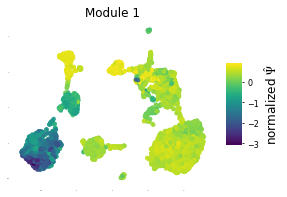

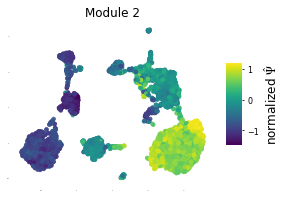

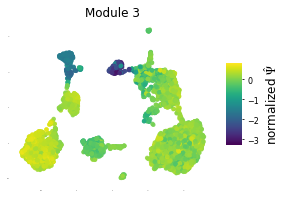

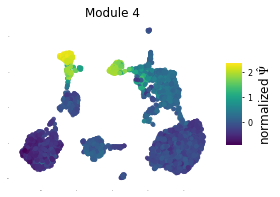

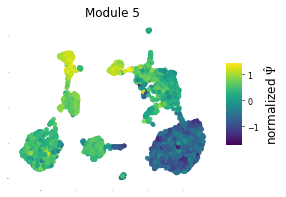

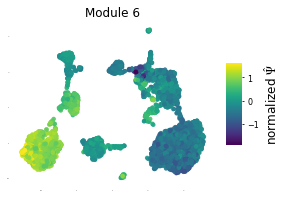

In [20]:
psix_object.plot_modules('plots/')

### Top scoring exon

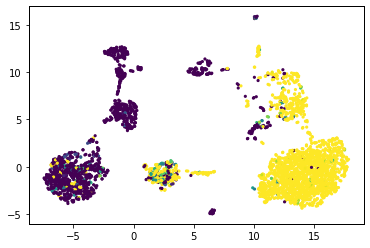

In [34]:
from matplotlib import pyplot as plt
plt.scatter(psix_object.latent.iloc[:,0], psix_object.latent.iloc[:,1],
            c = psix_object.adata.uns['psi']['Capzb_3'], linewidth=0, s=10)